## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
torch.cuda.set_device(0)

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/cedric/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/cedric/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/cedric/.fastai/data/camvid/labels'),
 PosixPath('/home/cedric/.fastai/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [ ]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/cedric/.fastai/data/camvid/images/Seq05VD_f03600.png'),
 PosixPath('/home/cedric/.fastai/data/camvid/images/0016E5_08099.png'),
 PosixPath('/home/cedric/.fastai/data/camvid/images/0001TP_007800.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/cedric/.fastai/data/camvid/labels/Seq05VD_f02670_P.png'),
 PosixPath('/home/cedric/.fastai/data/camvid/labels/Seq05VD_f03030_P.png'),
 PosixPath('/home/cedric/.fastai/data/camvid/labels/Seq05VD_f03090_P.png')]

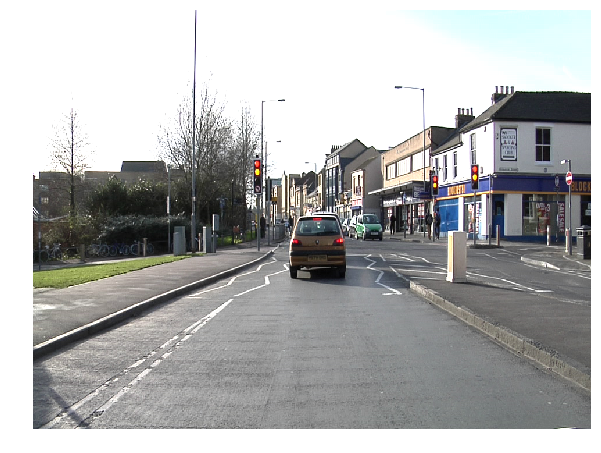

In [7]:
img_f = fnames[3] # fourth image
img = open_image(img_f)
img.show(figsize=(10,10))

In [8]:
get_y_fn = lambda x: path_lbl / f'{x.stem}_P{x.suffix}'

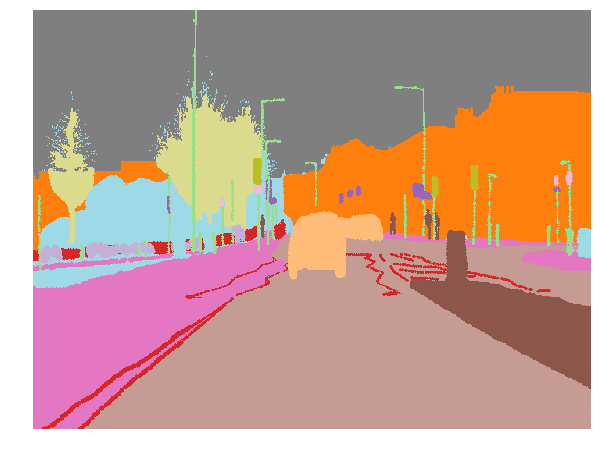

In [9]:
mask = open_mask(get_y_fn(img_f)) # type of vision.image.ImageSegment
mask.show(figsize=(10,10), alpha=1)

In [10]:
# Sanity check
mask.shape, mask.shape[1:]

(torch.Size([1, 720, 960]), torch.Size([720, 960]))

In [11]:
src_size = np.array(mask.shape[1:])
src_size, mask.data # Return this image pixels as a `LongTensor`.

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [18, 18, 18,  ..., 17, 17, 17],
          [18, 18, 18,  ..., 17, 17, 17],
          [18, 18, 18,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str) # Load data from a text file.
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [13]:
# These two slashes in Python means integer divide because obviously we can't have half pixel amounts in our sizes.
size = src_size // 2
bs = 4 # note that the original value is 8. I'm using Google Cloud Tesla P4 GPU with 8 GB of memory

In [19]:
# SegmentationItemList is ItemList suitable for segmentation tasks. It returns ImageItemList type.
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt') # Split the data by using the names in valid.txt for the validation set
       .label_from_func(get_y_fn, classes=codes)) # Apply `func` to every input to get its label (mask). Call get_label_cls func which decide the type of category list

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

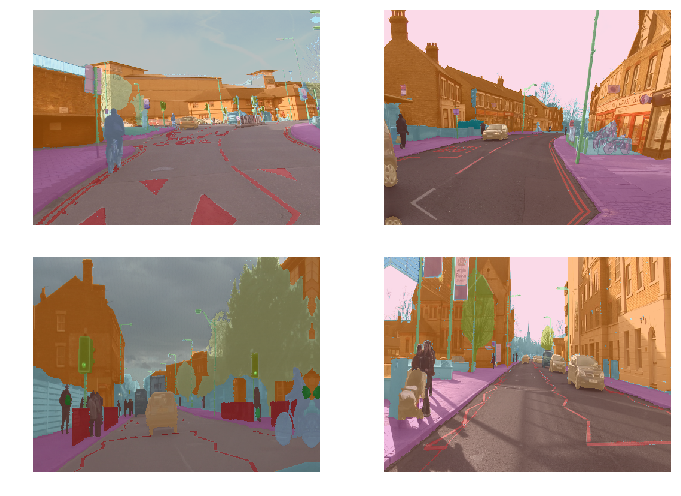

In [16]:
data.show_batch(2, figsize=(10,7))

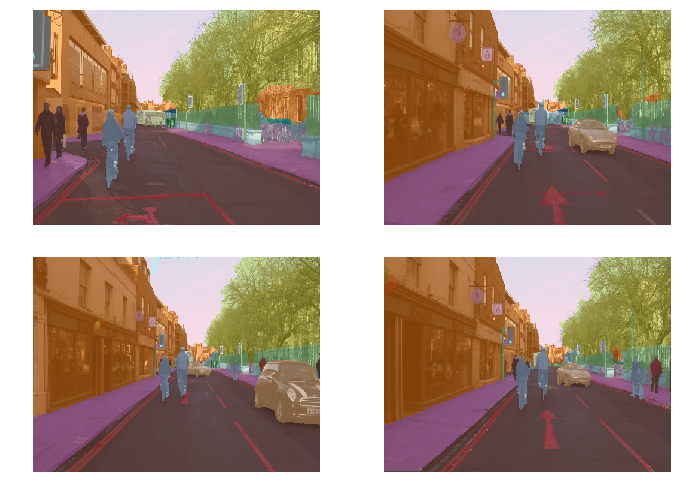

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [14]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1) # If target size is 2x1x2x1, this will squeeze dimension 1, so target size is 2x2x1
    mask = target != void_code # get mask without Void pixels
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [15]:
metrics = acc_camvid
# metrics=accuracy

In [16]:
wd = 1e-2 # weight decay

For segmentation, we don't just create a convolutional neural network. We can, but actually an architecture called [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) turns out to be better.

**Build U-Net learners**

`unet_learner` module builds a dynamic U-Net (`vision.models.unet.DynamicUnet` class) from any backbone pretrained on ImageNet, automatically inferring the intermediate sizes. For more details, refer to fastai docs for [Segmentation model](https://docs.fast.ai/basic_train#Segmentation-model).

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
lr_find(learn)

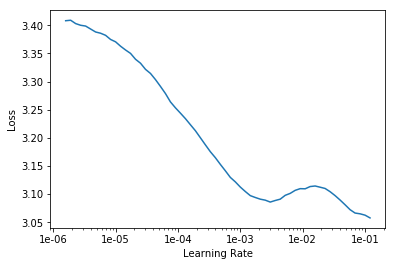

In [45]:
learn.recorder.plot(15, 0)

In [46]:
lr = 3e-3

In [50]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid
1,2.437675,2.122852,0.771331
2,2.236939,1.859043,0.844485
3,2.003604,1.702650,0.834142
4,1.662635,1.251454,0.859801
5,1.297252,1.061939,0.851625
6,0.966190,0.706364,0.904642
7,0.740949,0.545143,0.886771
8,0.645309,0.465408,0.898172
9,0.552206,0.423698,0.888123
10,0.442437,0.325265,0.914578


In [51]:
learn.save('stage-1')

In [52]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (600 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/cedric/.fastai/data/camvid/images
x: SegmentationItemList (600 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/cedric/.fastai/data/camvid/images;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/cedric/.fastai/data/camvid/images
x: SegmentationItemList (101 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/cedric/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), str

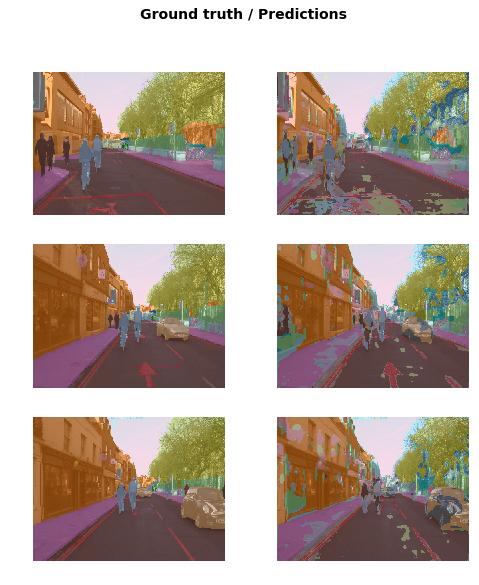

In [53]:
learn.show_results(rows=3, figsize=(8,9))

In [54]:
learn.unfreeze()

In [56]:
lrs = slice(lr/400, lr/4)

In [57]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.424506,0.325347,0.915800
2,0.401341,0.309814,0.922001
3,0.402865,0.315523,0.920738
4,0.385111,0.310828,0.921451
5,0.373398,0.318591,0.920694
6,0.373854,0.341632,0.912354
7,0.356029,0.321978,0.918462
8,0.348573,0.279322,0.926869
9,0.344290,0.310897,0.919518
10,0.331908,0.306674,0.917737


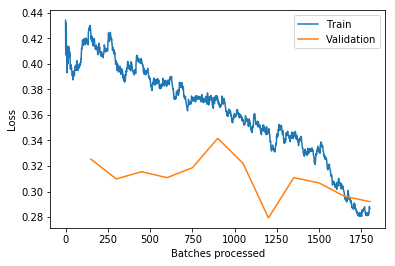

In [59]:
learn.recorder.plot_losses()

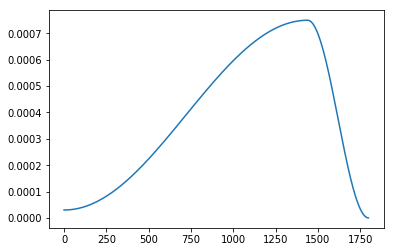

In [60]:
learn.recorder.plot_lr()

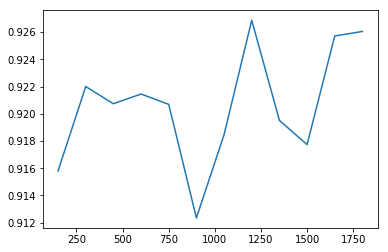

In [61]:
learn.recorder.plot_metrics()

In [62]:
learn.save('stage-2')

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [17]:
size = src_size # 720 x 960
bs = 2

In [20]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [22]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (600 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/cedric/.fastai/data/camvid/images
x: SegmentationItemList (600 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/cedric/.fastai/data/camvid/images;

Valid: LabelList
y: SegmentationLabelList (101 items)
[ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960), ImageSegment (1, 720, 960)]...
Path: /home/cedric/.fastai/data/camvid/images
x: SegmentationItemList (101 items)
[Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960), Image (3, 720, 960)]...
Path: /home/cedric/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), str

In [23]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 168.75 MiB (GPU 0; 7.43 GiB total capacity; 6.05 GiB already allocated; 126.94 MiB free; 631.60 MiB cached)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


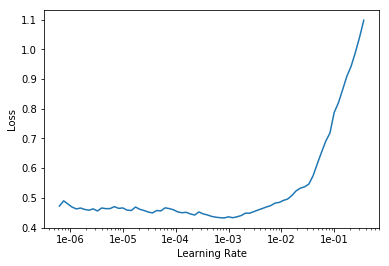

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

Total time: 15:41
epoch  train_loss  valid_loss  acc_camvid
1      0.382982    0.337384    0.904437    (01:40)
2      0.363525    0.312738    0.913709    (01:33)
3      0.345842    0.281208    0.918837    (01:33)
4      0.332908    0.315401    0.911936    (01:33)
5      0.337121    0.315564    0.911719    (01:33)
6      0.326914    0.283248    0.919347    (01:33)
7      0.311748    0.303021    0.913213    (01:33)
8      0.312433    0.264381    0.925357    (01:33)
9      0.274042    0.265071    0.921500    (01:33)
10     0.244084    0.239709    0.931215    (01:33)



In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

Total time: 16:49
epoch  train_loss  valid_loss  acc_camvid
1      0.224315    0.243748    0.929659    (01:39)
2      0.233819    0.256230    0.925163    (01:41)
3      0.216598    0.248363    0.929304    (01:41)
4      0.217467    0.242487    0.930903    (01:41)
5      0.221290    0.247053    0.930387    (01:41)
6      0.208421    0.249250    0.929263    (01:41)
7      0.202845    0.240715    0.931511    (01:41)
8      0.197734    0.244688    0.930260    (01:41)
9      0.195650    0.249368    0.929931    (01:40)
10     0.192460    0.248666    0.929322    (01:41)



In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big')

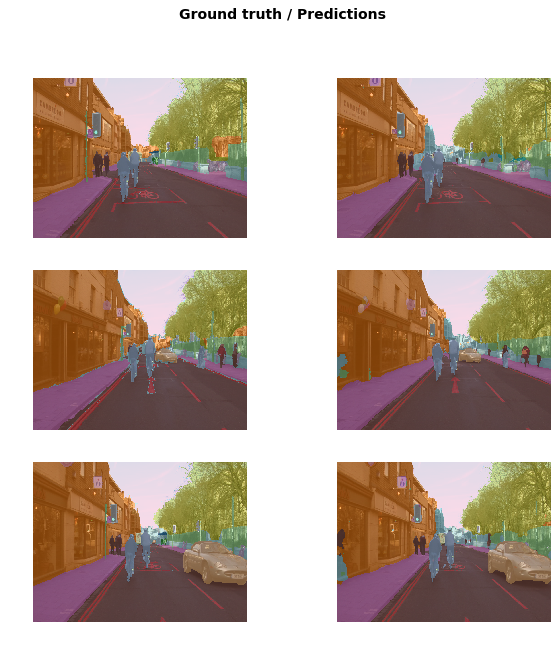

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin